<a href="https://colab.research.google.com/github/PrettyCharity/Bigquery/blob/main/Chicago_Taxi_Trips_Bigquery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Google Cloud Credentials
import os
from google.cloud import bigquery
# Credentials and the path
credential_path = "key.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_path

In [2]:
#@title Accessing the 'chicago_taxi_trips' via bigquery object
client = bigquery.Client()
dataset_ref = client.dataset('chicago_taxi_trips', project = 'bigquery-public-data')
dataset = client.get_dataset(dataset_ref)

In [3]:
#@title Exploring the tables of chicago_taxi_trips
tables = client.list_tables(dataset)
for table in tables:
  print(table.table_id)

taxi_trips


In [4]:
#@title Obtaining 'taxi_trips' table
table_ref = dataset_ref.table('taxi_trips')
table = client.get_table(table_ref)
preview = client.list_rows(table, max_results = 5).to_dataframe()
print('Table columns:\n\n')
print(preview.columns)

Table columns:


Index(['unique_key', 'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp',
       'trip_seconds', 'trip_miles', 'pickup_census_tract',
       'dropoff_census_tract', 'pickup_community_area',
       'dropoff_community_area', 'fare', 'tips', 'tolls', 'extras',
       'trip_total', 'payment_type', 'company', 'pickup_latitude',
       'pickup_longitude', 'pickup_location', 'dropoff_latitude',
       'dropoff_longitude', 'dropoff_location'],
      dtype='object')


In [5]:
#@title Construct the SQL query to determine # of trips and average speed per hour between January - July 2017
query = """
            WITH RelevantRides AS
            (
               SELECT EXTRACT(HOUR FROM trip_start_timestamp) AS hour_of_day, 
                       trip_seconds, trip_miles 
               FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
               WHERE trip_start_timestamp > '2017-01-01' AND 
                     trip_start_timestamp < '2017-07-01'AND 
                     trip_seconds >0 AND trip_miles > 0
            )
            SELECT hour_of_day, COUNT(1) AS num_trips,
                       3600 * SUM(trip_miles) / SUM(trip_seconds) AS avg_mph
            FROM RelevantRides
            GROUP BY hour_of_day
            ORDER BY hour_of_day
       """  


In [6]:
#@title Fetch data from the server and show the results
# API request - run the query, and convert the results to a pandas DataFrame
query_job = client.query(query)
speed = query_job.to_dataframe()

speed.style

,hour_of_day,num_trips,avg_mph
0,0,319339,20.230524
1,1,266529,18.937621
2,2,210147,18.777070
3,3,159668,20.158048
4,4,122183,26.736014
5,5,119312,30.769172
6,6,182738,24.588313
7,7,358406,17.735967
8,8,541775,15.079892
9,9,565548,16.543882


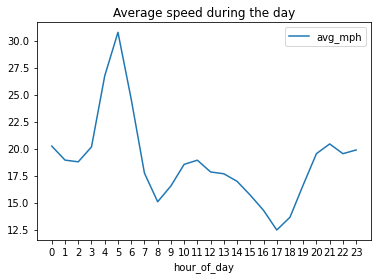

In [11]:
#@title Plotting the speed data
speed.plot(x = 'hour_of_day', y = 'avg_mph', kind = 'line', title = 'Average speed during the day', xticks = range(0, 24))